# Symbolic computing for ML

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
import sys
import sympy as sy
from IPython.display import Image
%load_ext tensorboard
sy.init_printing(use_latex=True)    
import tensorflow as tf
tf.__version__

2024-12-10 17:19:50.860339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.14.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

(150, 2)


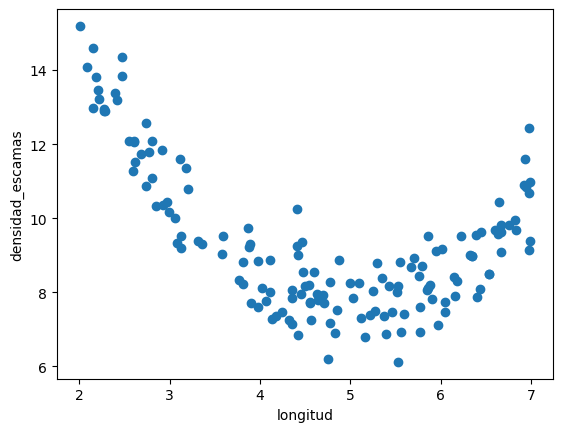

In [3]:
d = pd.read_csv("local/datasets/trilotropicos.csv")
print(d.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

### Let's define a simple loss function

$$\mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} ({\bf{w}}^T{\bf{x}}_i- y_i)^2 $$

The gradient of $\mathcal{L}(\cdot)$ is:

$$\nabla \mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} ({\bf{w}}^T{\bf{x}}_i -y_i ) {\bf{x}}_i$$


In [4]:
y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T


def n_cost(t):
    return np.mean((X.dot(t)-y)**2)

def n_grad(t):
    return 2*X.T.dot(X.dot(t)-y)/len(X)

init_t = np.random.random()*40-5, np.random.random()*20-10
r = minimize(n_cost, init_t, method="BFGS", jac=n_grad)
r

      fun: 2.7447662570809355
 hess_inv: array([[ 5.49985723, -1.07531773],
       [-1.07531773,  0.23126819]])
      jac: array([-2.44934669e-08,  2.52831629e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([12.68999516, -0.71805846])

## Using `sympy` computer algebra system (CAS)

In [5]:
x,y = sy.symbols("x y")

In [6]:
z = x**2 + x*sy.cos(y)
z

we can evaluate the expresion by providing concrete values for the symbolic variables

In [7]:
z.subs({x: 2, y: sy.pi/4})


In [8]:
z.subs({x: 2})

and obtain numerical approximations of these values

In [9]:
sy.N(z.subs({x: 2, y: sy.pi/4}))

a **derivative** can be seen as a function that inputs and expression and outputs another expression

observe how we compute $\frac{\partial z}{\partial x}$ and $\frac{\partial z}{\partial y}$

In [10]:
z.diff(x)

In [11]:
z.diff(y)

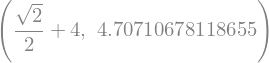

In [12]:
r = z.diff(x).subs({x: 2, y: sy.pi/4})
r, sy.N(r)

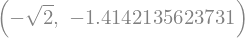

In [13]:
r = z.diff(y).subs({x: 2, y: sy.pi/4})
r, sy.N(r)

How is this done?

## Computational graph

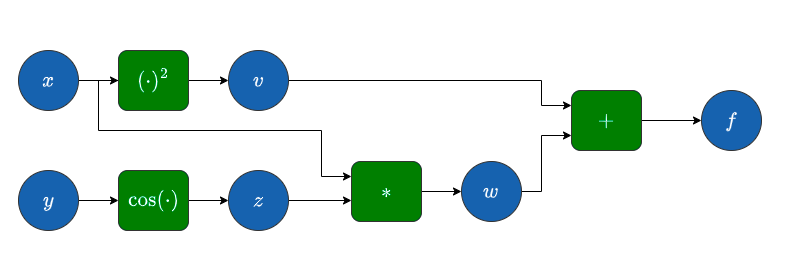

In [14]:
Image("local/imgs/ComputationalGraph.png")

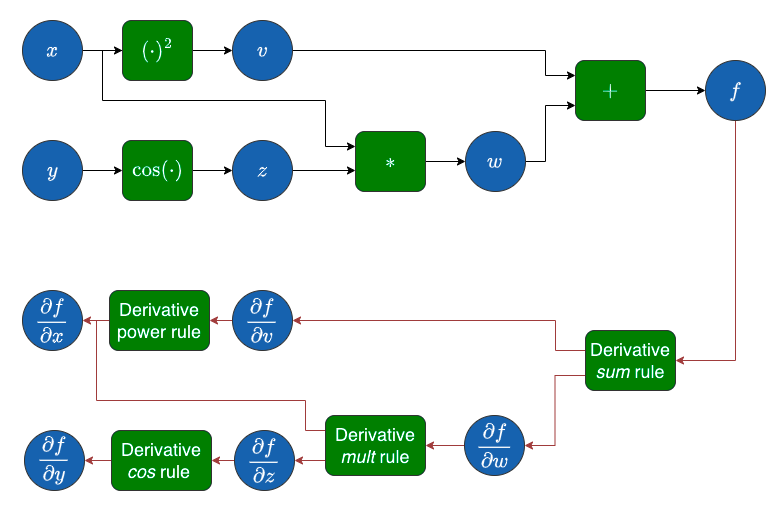

In [15]:
Image("local/imgs/ComputationalGraph2.png")

### A symbolic computational package can do a lot of things:

In [16]:
sy.expand((x+2)**2)

In [17]:
sy.factor( x**2-2*x-8 )

In [18]:
sy.solve( x**2 + 2*x - 8, x)

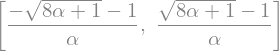

In [19]:
a = sy.symbols("alpha")
sy.solve( a*x**2 + 2*x - 8, x)


differential equations, solving $\frac{df}{dt}=f(t)+t$

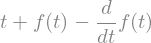

In [20]:
t, C1 = sy.symbols("t C1")
f = sy.symbols("f", cls=sy.Function)
dydt = f(t)+t
eq = dydt-sy.diff(f(t),t)
eq

In [21]:
yt = sy.dsolve(eq, f(t))
yt

 systems of equations

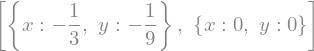

In [22]:
sy.solve ([x**2+y, 3*y-x])

## `Sympy` to `Python` and `Numpy`

See [Sympy Numeric Computation](http://docs.sympy.org/latest/modules/numeric-computation.html)


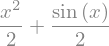

In [23]:
f = (sy.sin(x) + x**2)/2
f

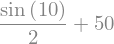

In [24]:
f.subs({x:10})

In [25]:
sy.N(f.subs({x:10}))

In [26]:
f1 = sy.lambdify(x, f)
f1(10)

and a vectorized version

In [27]:
f2 = sy.lambdify(x, f, "numpy")

In [28]:
f2(10)

In [29]:
f2(np.array([10,2,3]))

array([49.72798944,  2.45464871,  4.57056   ])

the _lambdified_ version is faster, and the vectorized one is even faster

In [30]:
%timeit sy.N(f.subs({x:10}))

124 µs ± 3.06 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
%timeit f1(10)

1.28 µs ± 66.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [32]:
%timeit [f1(i) for i in range(1000)]

1.37 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
%timeit f2(np.arange(1000))

15.8 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Let's remember the loss function we defined before:

$$\mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} ({\bf{w}}^T{\bf{x}}_i- y_i)^2 $$

The gradient of $\mathcal{L}(\cdot)$ is:

$$\nabla \mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} ({\bf{w}}^T{\bf{x}}_i -y_i ) {\bf{x}}_i$$

## Using `sympy` to obtain the gradient.

In [34]:
y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T

w0,w1 = sy.symbols("w_0 w_1")
w0,w1

we first obtain the cost expression for a few summation terms, so that we can print it out and understand it

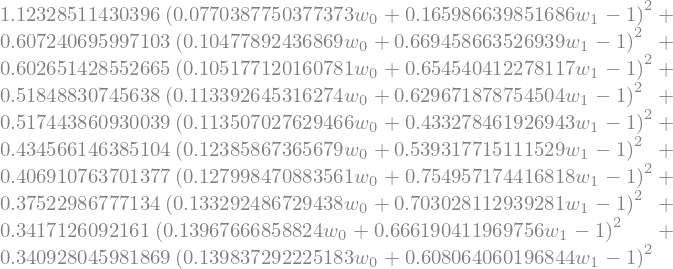

In [35]:
L = 0
for i in range(10):
    L += (X[i,0]*w0+X[i,1]*w1-y[i])**2
L = L/len(X)
L

we can now simplify the expression, using `sympy` mechanics

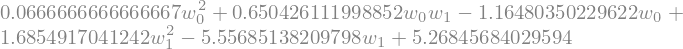

In [36]:
L = L.simplify()
L

we now build the full expression

In [37]:
def build_regression_cost_expression(X,y):
    expr_cost = 0
    for i in range(len(X)):
        expr_cost += (X[i,0]*w0+X[i,1]*w1-y[i])**2/len(X)
    expr_cost = expr_cost.simplify()
    return expr_cost

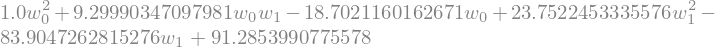

In [38]:
y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T

expr_cost = build_regression_cost_expression(X,y)
expr_cost

obtain derivatives symbolically

In [39]:
expr_dw0 = expr_cost.diff(w0)
expr_dw1 = expr_cost.diff(w1)
expr_dw0, expr_dw1

and obtain regular Python so that we can use them in optimization

In [40]:
s_cost = sy.lambdify([[w0,w1]], expr_cost, "numpy")

d0 = sy.lambdify([[w0,w1]], expr_dw0, "numpy")
d1 = sy.lambdify([[w0,w1]], expr_dw1, "numpy")
s_grad = lambda x: np.array([d0(x), d1(x)])

and now we can minimize

In [41]:
r = minimize(s_cost, [0,0], jac=s_grad, method="BFGS")
r

      fun: 2.7447662570799594
 hess_inv: array([[ 5.57425906, -1.09086733],
       [-1.09086733,  0.23434848]])
      jac: array([-1.73778293e-07, -9.26928138e-07])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([12.6899981, -0.7180591])

observe that hand derived functions and the ones obtained by `sympy` evaluate to the same values

In [42]:
w0 = np.random.random()*5+10
w1 = np.random.random()*4-3
w = np.r_[w0,w1]

print ("theta:",w)
print ("cost analytic:", n_cost(w))
print ("cost symbolic:", s_cost(w))

print ("gradient analytic:", n_grad(w))
print ("gradient symbolic:", s_grad(w))

theta: [10.98668483  0.37723461]
cost analytic: 16.790694513357096
cost symbolic: 16.790694513357067
gradient analytic: [ 6.77949907 36.19071996]
gradient symbolic: [ 6.77949907 36.19071996]


<div class="alert alert-block alert-success"><b>Problems of CAS por Deep Learning</b>

- Expression swell
- Multidimensional vector-valued functions require additional contructs beyond algebraic expressions:
    - Gradient
    - Jacobian
    - Hessian
    - Jacobian vector products (jvp): $J_g(\theta){\bf v}$
    - Vector jacobian products (vjp): ${\bf u}^\top J_g(\theta)$

 The partial derivatives are mainly built on top of jvp and vjp operators. **Note** that $\frac{\partial g}{\partial \theta_i}$ is just the $i$-column vector of the Jacobian, or the jvp when the vector ${\bf v} = [0,\cdots,i,\cdots,0]$ where $i=1$, or, even more efficiently using vjp.
</div>